# Data collection and preprocessing

In [ ]:
#Course Project: Candidate Advertisement List Recommendation Engine
#221100663, Moustafa Ahmed Mohamed El Demery
#A20000763, Mohamed Ayman Mohamed Abdelwahab


In [ ]:
!pip install scikit-surprise
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357278 sha256=d9084f1f1179cf2d3f8a068be19e3227fc566edd6d5890e3f63b7e48eac0a722
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552449 sha256=36ee18d40bf2b31860b26dd78bfa93e4829666d9cddfa91a2e780b494b4cb567
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==================================================
# Step 1: Load and Preprocess Data
# ==================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training and testing datasets
train_file_path = "/content/drive/MyDrive/python/train.csv"
test_file_path = "/content/drive/MyDrive/python/test.csv"

train_data = pd.read_csv(train_file_path, nrows=10000)  # Adjust nrows based on your memory
test_data = pd.read_csv(test_file_path, nrows=10000)  # Adjust nrows based on your memory

# Fill missing values (if any)
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)


In [ ]:
# ==================================================
# Step 2: Analyze Click Distribution in Training Data
# ==================================================
# Calculate the click rate in the training data
click_rate = train_data['click'].mean()
print(f"Click rate in training data: {click_rate:.2%}")

Click rate in training data: 17.06%


'click' column does not exist in the test data. Simulating click distribution based on training data.


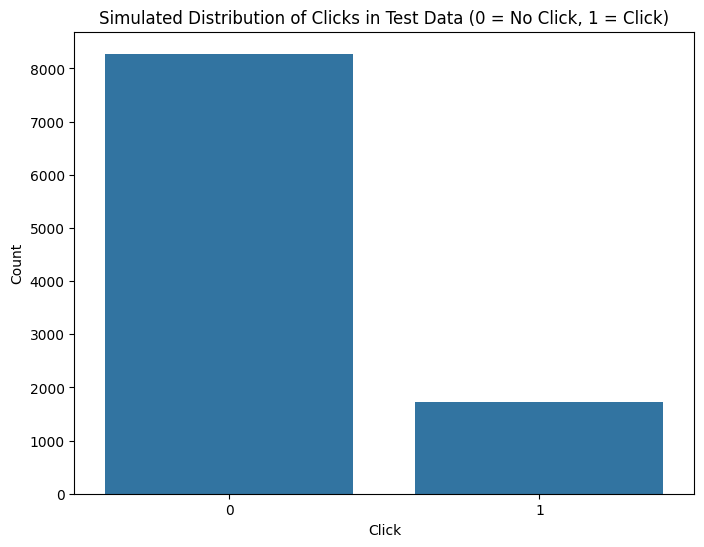

In [ ]:
# ==================================================
# Step 3: Simulate Click Distribution in Test Data
# ==================================================
# Check if 'click' column exists in the test data
if 'click' in test_data.columns:
    print("'click' column exists in the test data.")
else:
    print("'click' column does not exist in the test data. Simulating click distribution based on training data.")

    # Simulate clicks in the test data based on the click rate from the training data
    test_data['click'] = np.random.choice([0, 1], size=len(test_data), p=[1 - click_rate, click_rate])

    # Visualize the simulated click distribution in the test data
    plt.figure(figsize=(8, 6))
    sns.countplot(x='click', data=test_data)
    plt.title('Simulated Distribution of Clicks in Test Data (0 = No Click, 1 = Click)')
    plt.xlabel('Click')
    plt.ylabel('Count')
    plt.show()

In [ ]:
# ==================================================
# Step 4: Preprocess the Data
# ==================================================
# Function to preprocess the data
def preprocess_data(data):
    # Convert 'hour' to datetime format
    if 'hour' in data.columns:
        data['hour'] = pd.to_datetime(data['hour'], format='%y%m%d%H')

        # Extract day of the week and hour of the day
        data['day_of_week'] = data['hour'].dt.dayofweek  # Monday=0, Sunday=6
        data['hour_of_day'] = data['hour'].dt.hour

        # Drop the original 'hour' column
        data = data.drop(columns=['hour'])

    # Label encoding for 'device_type'
    if 'device_type' in data.columns:
        label_encoder = LabelEncoder()
        data['device_type'] = label_encoder.fit_transform(data['device_type'])

    # One-hot encoding for 'site_category'
    if 'site_category' in data.columns:
        data = pd.get_dummies(data, columns=['site_category'], drop_first=True)

    # Normalize numerical features
    numerical_features = ['C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
    for feature in numerical_features:
        if feature in data.columns:
            scaler = MinMaxScaler()
            data[feature] = scaler.fit_transform(data[[feature]])

    # Create unique IDs for users and ads
    if 'device_ip' in data.columns:
        data['user_id'] = data.groupby('device_ip').ngroup()  # Use 'device_ip' as a proxy for user_id
    if 'id' in data.columns:
        data['ad_id'] = data.groupby('id').ngroup()  # Use 'id' as a proxy for ad_id

    # Drop unnecessary columns
    columns_to_drop = ['device_ip', 'id']
    for col in columns_to_drop:
        if col in data.columns:
            data = data.drop(columns=[col])

    return data

# Preprocess the training and testing data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Save the preprocessed datasets
train_data.to_csv("/content/drive/MyDrive/python/train_preprocessed.csv", index=False)
test_data.to_csv("/content/drive/MyDrive/python/test_preprocessed.csv", index=False)

print("Training and testing data preprocessed and saved.")


Training and testing data preprocessed and saved.


Model saved to /content/drive/MyDrive/python/collab_filtering_model.pkl
Collaborative filtering scores matrix saved.
RMSE: 0.3917
MAE:  0.2856
Collaborative Filtering RMSE: 0.39174010847822927
Collaborative Filtering MAE: 0.28560602861676615
AUC-ROC: 0.5006
Log Loss: 0.8048
Precision: 0.1429
Recall: 0.0023
F1-Score: 0.0046


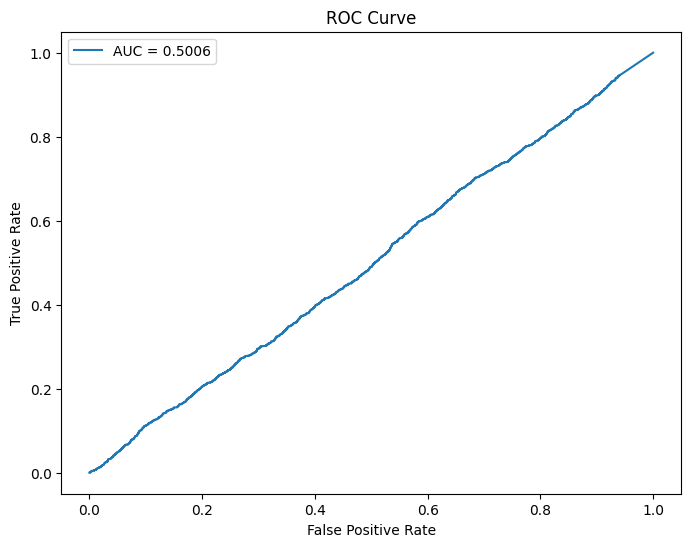

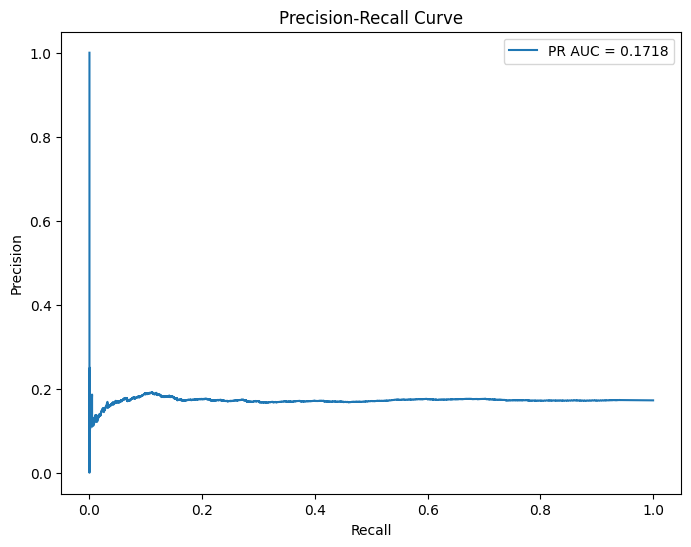

In [ ]:
# ==================================================
# Step 5: Collaborative Filtering (CF)
# ==================================================
from surprise import SVD, Dataset, Reader
from surprise import accuracy
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, precision_recall_curve, auc ,precision_score, recall_score, f1_score, accuracy_score
import joblib

# Prepare the training data for Collaborative Filtering
if 'click' in train_data.columns:
    train_collab_data = train_data[['user_id', 'ad_id', 'click']]
    train_collab_data = train_collab_data.rename(columns={'click': 'rating'})

    # Create a Surprise-compatible dataset
    reader = Reader(rating_scale=(0, 1))  # Click (1) or no click (0)
    train_data_surprise = Dataset.load_from_df(train_collab_data[['user_id', 'ad_id', 'rating']], reader)

    # Build the full training set
    trainset = train_data_surprise.build_full_trainset()

    # Train the SVD model
    model = SVD()
    model.fit(trainset)

    # Save the trained model
    model_path = "/content/drive/MyDrive/python/collab_filtering_model.pkl"
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

    # Prepare the testing data for Collaborative Filtering
    if 'click' in test_data.columns:
        test_collab_data = test_data[['user_id', 'ad_id', 'click']]
        test_collab_data = test_collab_data.rename(columns={'click': 'rating'})

        # Create a Surprise-compatible dataset for testing
        test_data_surprise = Dataset.load_from_df(test_collab_data[['user_id', 'ad_id', 'rating']], reader)

        # Build the test set
        testset = test_data_surprise.build_full_trainset().build_testset()

        # Generate predictions for the test set
        predictions = model.test(testset)

        # Extract predicted scores
        collab_scores = [pred.est for pred in predictions]

        # Create a DataFrame to store the predictions
        predictions_df = pd.DataFrame({
            'user_id': [pred.uid for pred in predictions],
            'ad_id': [pred.iid for pred in predictions],
            'predicted_score': collab_scores
        })

        # Pivot the DataFrame to create a user-ad matrix
        collab_scores_matrix = predictions_df.pivot(index='user_id', columns='ad_id', values='predicted_score')

        # Fill missing values with 0 (no interaction)
        collab_scores_matrix = collab_scores_matrix.fillna(0)

        # Save collab_scores_matrix to a file
        np.save("/content/drive/MyDrive/python/collab_scores_matrix.npy", collab_scores_matrix.values)
        print("Collaborative filtering scores matrix saved.")

        # Evaluate the model using RMSE, MAE, AUC-ROC, and Log Loss , precision , recall , F1-score
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        print(f"Collaborative Filtering RMSE: {rmse}")
        print(f"Collaborative Filtering MAE: {mae}")

        y_true = [pred.r_ui for pred in predictions]
        y_pred = [pred.est for pred in predictions]

        auc_roc = roc_auc_score(y_true, y_pred)
        logloss = log_loss(y_true, y_pred)
        print(f"AUC-ROC: {auc_roc:.4f}")
        print(f"Log Loss: {logloss:.4f}")

        y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
        precision = precision_score(y_true, y_pred_binary)
        recall = recall_score(y_true, y_pred_binary)
        f1 = f1_score(y_true, y_pred_binary)

        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        # ======================================================
        # Step 6: Visualize ROC Curve and Precision-Recall Curve
        # ======================================================
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()
    else:
        print("'click' column not found in test data. Skipping evaluation.")
else:
    print("'click' column not found in training data. Skipping Collaborative Filtering.")

In [ ]:
# ==================================================
# Step 6: Content-Based Filtering (CB)
# ==================================================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine candidate and ad features into a single text feature
train_data['combined_features'] = (
    train_data['device_type'].astype(str) + " " +
    train_data['site_category_28905ebd'].astype(str) + " " +
    train_data['app_category'].astype(str) + " " +
    train_data['banner_pos'].astype(str)
)

# Create TF-IDF vectors
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(train_data['combined_features'])

# Compute cosine similarity between candidate profiles and ad features
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get top N recommendations based on cosine similarity
def get_top_recommendations(cosine_sim, candidate_index, top_n=10):
    sim_scores = list(enumerate(cosine_sim[candidate_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_recommendations = [i for i, _ in sim_scores[1:top_n+1]]
    return top_recommendations

# Generate recommendations for the first candidate
candidate_index = 0
top_recommendations = get_top_recommendations(cosine_sim, candidate_index, top_n=10)

# Display the top recommendations
print("\nTop 10 Content-Based Filtering Recommendations:")
print(f"Top 10 recommendations for candidate {candidate_index}: {top_recommendations}")


Top 10 Content-Based Filtering Recommendations:
Top 10 recommendations for candidate 0: [1, 2, 3, 8, 11, 15, 17, 18, 21, 23]


In [ ]:
# ==================================================
# Step 7: Hybrid Model (CF + CB)
# ==================================================
# Load collab_scores from the file
collab_scores = np.load("/content/drive/MyDrive/python/collab_scores_matrix.npy")

# Define weights for content-based and collaborative filtering
content_weight = 0.7
collab_weight = 0.3

# Get the common users between cosine_sim and collab_scores
common_users = collab_scores_matrix.index.intersection(range(cosine_sim.shape[0]))

# Filter cosine_sim and collab_scores to include only common users
filtered_cosine_sim = cosine_sim[common_users, :]
filtered_collab_scores = collab_scores[common_users.get_indexer(common_users), :] #Adjust collab_scores to the index

# Combine scores using a weighted average for common users
hybrid_scores = (content_weight * filtered_cosine_sim) + (collab_weight * filtered_collab_scores)

# Generate recommendations using the hybrid scores for common users
# Change here: Use len(hybrid_scores) instead of len(train_data)
top_hybrid_recommendations = get_top_recommendations(hybrid_scores, candidate_index, top_n=10)
print("\nTop 10 Hybrid Recommendations:")
print(f"Top 10 hybrid recommendations for candidate {candidate_index}: {top_hybrid_recommendations}")

# Save hybrid recommendations to a CSV file
# Change here: Use len(hybrid_scores) instead of len(train_data)
hybrid_recommendations_df = pd.DataFrame({
    'candidate_index': range(len(hybrid_scores)),
    'top_hybrid_recommendations': [get_top_recommendations(hybrid_scores, i, top_n=10) for i in range(len(hybrid_scores))]
})

hybrid_recommendations_df.to_csv("/content/drive/MyDrive/python/hybrid_recommendations.csv", index=False)
print("Hybrid recommendations saved.")


Top 10 Hybrid Recommendations:
Top 10 hybrid recommendations for candidate 0: [0, 1, 2, 3, 8, 11, 15, 17, 18, 21]
Hybrid recommendations saved.


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
# ==================================================
# Step 8: User Interface (UI) with Streamlit
# ==================================================
import streamlit as st

def main():
    st.title("Candidate Advertisement List Recommendation Engine")
    st.write("This system provides personalized ad recommendations using a hybrid approach (Collaborative Filtering + Content-Based Filtering).")

    # Load the trained model and data
    model = joblib.load("/content/drive/MyDrive/python/collab_filtering_model.pkl")
    collab_scores = np.load("/content/drive/MyDrive/python/collab_scores_matrix.npy")
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # User input
    user_id = st.number_input("Enter User ID:", min_value=0, max_value=len(train_data) - 1, value=0)
    top_n = st.number_input("Number of Recommendations:", min_value=1, max_value=20, value=10)

    # Generate recommendations
    if st.button("Get Recommendations"):
        # Collaborative Filtering Scores
        cf_scores = collab_scores[user_id, :]

        # Content-Based Filtering Scores
        cb_scores = cosine_sim[user_id, :]

        # Hybrid Scores
        hybrid_scores = (content_weight * cb_scores) + (collab_weight * cf_scores)

        # Get top N recommendations
        top_recommendations = np.argsort(hybrid_scores)[-top_n:][::-1]

        # Display recommendations
        st.write(f"Top {top_n} Recommendations for User {user_id}:")
        for i, ad_id in enumerate(top_recommendations):
            st.write(f"{i + 1}. Ad ID: {ad_id}, Score: {hybrid_scores[ad_id]:.4f}")

if __name__ == "__main__":
    main()